Veri başarıyla yüklendi!

Pivot işlemi tamamlandı. 'Seasonal_Baseline' eklendi.
                 time  use [kW]  Month  Seasonal_Baseline
0 2016-01-01 05:00:00  0.932833      1           0.801527
1 2016-01-01 05:00:01  0.934333      1           0.801527
2 2016-01-01 05:00:02  0.931817      1           0.801527
3 2016-01-01 05:00:03  1.022050      1           0.801527
4 2016-01-01 05:00:04  1.139400      1           0.801527

Model eğitiliyor... (Mevsimsel Etki ile)
----------------------------------------
YENİ Model R2 Skoru (Mevsimsel): 0.5448
YENİ Hata Payı (MAE): 0.3118 kW
----------------------------------------


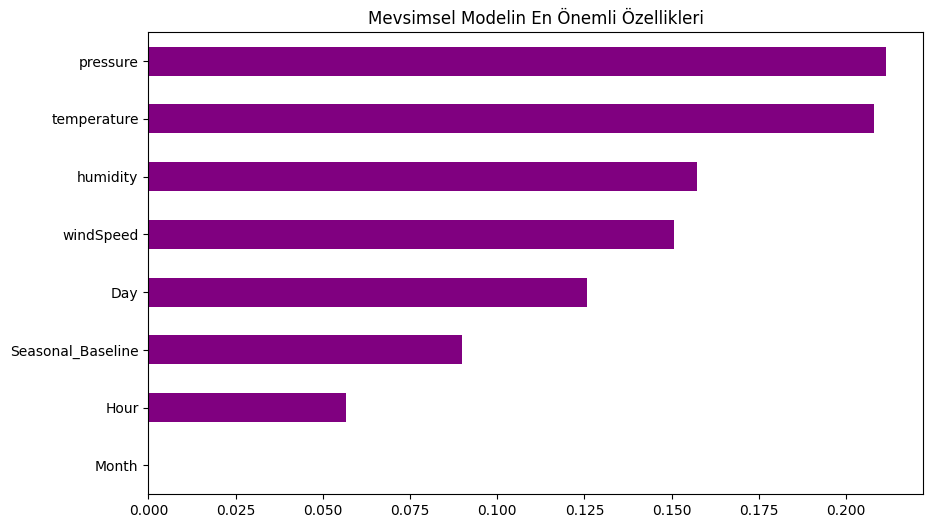

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. VERİ YÜKLEME
try:
    df = pd.read_csv('Smart Home Dataset.csv', low_memory=False)
    print("Veri başarıyla yüklendi!")
except FileNotFoundError:
    print("Hata: Dosya bulunamadı.")

# 2. VERİ ÖN İŞLEME
df['time'] = pd.to_datetime(df['time'], unit='s')
df['Hour'] = df['time'].dt.hour
df['Day'] = df['time'].dt.dayofweek
# [YENİ STRATEJİ] Ay bilgisini ekliyoruz. Enerji tüketimi mevsime göre çok değişir.
df['Month'] = df['time'].dt.month

df = df.dropna()
target_col = 'use [kW]'

# 3. MEVSİMSEL PIVOT (SEASONAL BASELINE)
# Strateji Değişikliği: Hafta sonu yerine "AY" (Month) kullanıyoruz.
# Soru: "Bu ayda ve bu saatte normalde ne kadar tüketim olur?"
pivot_table = df.pivot_table(values=target_col,
                             index=['Hour', 'Month'], # Burası değişiyor. saat + ay yaptım.
                             aggfunc='mean').reset_index()

pivot_table.rename(columns={target_col: 'Seasonal_Baseline'}, inplace=True)

# Ana tabloya ekle
df = df.merge(pivot_table, on=['Hour', 'Month'], how='left')

print("\nPivot işlemi tamamlandı. 'Seasonal_Baseline' eklendi.")
print(df[['time', target_col, 'Month', 'Seasonal_Baseline']].head())

# 4. MODEL HAZIRLIĞI
# Feature listesine 'Month' ve 'Seasonal_Baseline' ekledik
features = ['Hour', 'Day', 'Month', 'temperature', 'humidity', 'pressure', 'windSpeed', 'Seasonal_Baseline']

X = df[features]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. MODEL EĞİTİMİ
print("\nModel eğitiliyor... (Mevsimsel Etki ile)")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 6. SONUÇLAR
y_pred = rf_model.predict(X_test)

print("-" * 40)
print(f"YENİ Model R2 Skoru (Mevsimsel): {r2_score(y_test, y_pred):.4f}")
print(f"YENİ Hata Payı (MAE): {mean_absolute_error(y_test, y_pred):.4f} kW")
print("-" * 40)

# Özellik Önem Sıralaması
plt.figure(figsize=(10,6))
importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='purple')
plt.title('Mevsimsel Modelin En Önemli Özellikleri')
plt.show()